# 03_preprocess_clay — Reproject & mosaic clay fraction to the target grid

This notebook:
1. Reads the ROI and target grid template produced in `02_bbox_to_grid.ipynb`.
2. Loads a cached index of clay tiles with their geographic bounds.
3. Selects only tiles that **overlap** the ROI.
4. Reprojects each tile to the target grid (UTM, 200 m) and mosaics them.
5. Writes a Cloud-Optimized GeoTIFF (COG-ready) to `../data/outputs/aligned/clay/`.

**Assumptions**
- Clay tiles are GeoTIFFs on S3 (or local). The cache provides at least columns: `s3_href` and bounds (`west,east,south,north`) in EPSG:4326.
- Resampling policy for clay is **nearest** by default (preserves edges).


In [1]:
import os, math
from pathlib import Path
import numpy as np
import pandas as pd
import yaml
from shapely.geometry import box, Polygon
from shapely.ops import unary_union
import rasterio
from rasterio.crs import CRS
from rasterio.transform import Affine
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_origin
from rasterio.enums import Resampling as RioResampling
from rasterio import windows
import pyproj
from pyproj import Transformer
import fsspec
import s3fs

print('✅ Imports ok')

✅ Imports ok


## 1) Load config, ROI, and template grid

In [2]:
cfg_path = Path('../config/project.yaml')
if not cfg_path.exists():
    raise FileNotFoundError('Expected ../config/project.yaml — please create it first.')
with open(cfg_path, 'r') as f:
    cfg = yaml.safe_load(f)
roi = cfg['roi']
tgrid = cfg.get('target_grid', {})
template_path = Path(tgrid.get('template_path', '../data/outputs/aligned/_grid_template.tif'))
if not template_path.exists():
    raise FileNotFoundError(f'Template grid not found at {template_path}. Run 02_bbox_to_grid.ipynb first.')

with rasterio.open(template_path) as tmp:
    dst_crs = tmp.crs
    dst_transform = tmp.transform
    dst_height = tmp.height
    dst_width = tmp.width
    dst_nodata = tmp.nodata
    dst_bounds = tmp.bounds
print('Target CRS:', dst_crs)
print('Template:', template_path, '| shape:', (dst_height, dst_width))
print(dst_bounds)

Target CRS: EPSG:32611
Template: ../data/outputs/aligned/_grid_template.tif | shape: (623, 469)
BoundingBox(left=363600.0, bottom=3789200.0, right=457400.0, top=3913800.0)


## 2) Load clay tile index & select overlaps

In [13]:
def find_overlapping_clay_files(target_corners_latlon, clay_footprints_gdf):
    """
    Queries the clay footprints GeoDataFrame to find all tiles that overlap 
    the given target tile boundary.

    Args:
        tile_corners_latlon (dict): Dictionary containing the four Lon/Lat corners 
                                   (lon_sw, lat_sw, lon_se, lat_se, etc.) of the target tile.
        clay_footprints_gdf (gpd.GeoDataFrame): The GeoDataFrame of all source clay tiles.

    Returns:
        list: A list of dictionaries, where each dict contains the 'filename' and 'url' 
              of the overlapping clay files.
    """
    
    # 1. Define the target Tile Polygon from the input corners
    # Lon/Lat coords: (SW, SE, NE, NW, SW to close)
    target_polygon_coords = [
        (target_corners_latlon['lon_sw'], target_corners_latlon['lat_sw']),
        (target_corners_latlon['lon_se'], target_corners_latlon['lat_se']),
        (target_corners_latlon['lon_ne'], target_corners_latlon['lat_ne']),
        (target_corners_latlon['lon_nw'], target_corners_latlon['lat_nw']),
        (target_corners_latlon['lon_sw'], target_corners_latlon['lat_sw']) # Close
    ]
    
    target_tile_polygon = Polygon(target_polygon_coords)
    
    # 2. Use Spatial Index (sindex) for efficient querying
    
    # Find all potential matches whose bounding box overlaps the target tile's bounding box
    possible_matches_index = list(clay_footprints_gdf.sindex.intersection(target_tile_polygon.bounds))
    
    # Filter the GeoDataFrame to include only potential matches
    potential_matches = clay_footprints_gdf.iloc[possible_matches_index]
    
    # 3. Perform Final Geometric Intersection Check
    # Check if the target polygon truly intersects the geometry of the potential matches
    
    # Use GeoSeries for the target tile to check intersection against the filtered GDF
    target_tile_gs = gpd.GeoSeries([target_tile_polygon], crs="EPSG:4326")
    
    # Find tiles that intersect, then extract the relevant columns (filename, url)
    overlapping_tiles = potential_matches[potential_matches.intersects(target_tile_gs.iloc[0])]
    
    if overlapping_tiles.empty:
        return []
    
    # Return as a list of dictionaries for clean output
    return overlapping_tiles[['filename']].to_dict('records')

In [11]:
import s3fs
import geopandas as gpd

# 1. Initialize S3FileSystem (you already did this)
# This step makes the S3 bucket accessible.
fs = s3fs.S3FileSystem()

# 2. Define the correct S3 path to your Parquet file
# Based on your 'objs' list, the file is here:
S3_PARQUET_PATH = 's3://maap-ops-workspace/shared/xlxu220/ANCILLARY/SOIL_TEXTURE/local_clay_footprints.parquet'
local_clay_footprints_gdf = gpd.read_parquet(S3_PARQUET_PATH)
print("\n✅ Successfully loaded GeoDataFrame!")
print("\nGeoDataFrame Head:")
print(local_clay_footprints_gdf.head())
print(f"\nShape: {local_clay_footprints_gdf.shape}")


✅ Successfully loaded GeoDataFrame!

GeoDataFrame Head:
                 filename                                                url  \
0  tileSG-002-057_2-1.tif  /projects/3_Pre_processing/output_data_cache/t...   
1  tileSG-013-043_4-2.tif  /projects/3_Pre_processing/output_data_cache/t...   
2  tileSG-004-053_2-3.tif  /projects/3_Pre_processing/output_data_cache/t...   
3  tileSG-003-055_2-2.tif  /projects/3_Pre_processing/output_data_cache/t...   
4  tileSG-014-041_4-3.tif  /projects/3_Pre_processing/output_data_cache/t...   

                                            geometry  
0  POLYGON ((75.37379 70.45825, 79.83972 70.45825...  
1  POLYGON ((-7.58418 20.66799, -6.75432 20.66799...  
2  POLYGON ((40.8397 60.37529, 42.89159 60.37529,...  
3  POLYGON ((55.65495 65.24291, 58.48744 65.24291...  
4  POLYGON ((-14.08241 16.62557, -13.26229 16.625...  

Shape: (12953, 3)


In [15]:
# --- EXECUTION EXAMPLE ---
# Assume ALL_CLAY_URLS is your list of remote source file links
from shapely.geometry import Polygon

# Example Input (You would get this from your calculate_target_tile_corners function)
# 1. Define the target CRS (WGS84, which is Lat/Lon)
target_crs = CRS.from_string('EPSG:4326') 

# 2. Create a pyproj Transformer object
# The transformer converts coordinates FROM the source CRS TO the target CRS
transformer = Transformer.from_crs(dst_crs, target_crs, always_xy=True)

# 3. Define the four corner coordinates in the SOURCE CRS (UTM)
# Coordinates are in (x, y) format (e.g., (lon, lat) or (easting, northing))
corners_utm = {
    'sw': (dst_bounds.left, dst_bounds.bottom), # Southwest (left, bottom)
    'se': (dst_bounds.right, dst_bounds.bottom), # Southeast (right, bottom)
    'ne': (dst_bounds.right, dst_bounds.top),    # Northeast (right, top)
    'nw': (dst_bounds.left, dst_bounds.top),    # Northwest (left, top)
}
corners_latlon = {}
for key, (x, y) in corners_utm.items():
    lon, lat = transformer.transform(x, y) # transformer.transform returns (x, y) -> (lon, lat)
    corners_latlon[key] = {'lon': lon, 'lat': lat}

# 5. Format the result into the desired dictionary structure
# and apply the +/- 0.2 degree buffer

BUFFER = 0.2 # Lat/Lon buffer in degrees

EXAMPLE_target_CORNERS = {
    # Southwest
    'lon_sw': corners_latlon['sw']['lon'] - BUFFER, 
    'lat_sw': corners_latlon['sw']['lat'] - BUFFER,
    
    # Southeast
    'lon_se': corners_latlon['se']['lon'] + BUFFER, 
    'lat_se': corners_latlon['se']['lat'] - BUFFER,
    
    # Northeast
    'lon_ne': corners_latlon['ne']['lon'] + BUFFER, 
    'lat_ne': corners_latlon['ne']['lat'] + BUFFER,
    
    # Northwest
    'lon_nw': corners_latlon['nw']['lon'] - BUFFER, 
    'lat_nw': corners_latlon['nw']['lat'] + BUFFER
}
print("\n--- Transformed and Buffered Lat/Lon Corners ---")
for key, value in EXAMPLE_target_CORNERS.items():
    print(f"{key}: {value}")


 # Query for Overlapping Files
if local_clay_footprints_gdf is not None:
    overlapping_files = find_overlapping_clay_files(EXAMPLE_target_CORNERS, local_clay_footprints_gdf)
    
    if overlapping_files:
        print("\nFound Overlapping Clay Source Files:")
        for tile in overlapping_files:
            print(f"- {tile['filename']}")
    else:
        print("\nNo source clay files overlap the given target tile boundary.")
        
local_clay_files = [tile_info['filename'] for tile_info in overlapping_files]



--- Transformed and Buffered Lat/Lon Corners ---
lon_sw: -118.68105369479828
lat_sw: 34.03495725220231
lon_se: -117.26261918848851
lat_se: 34.04303025575299
lon_ne: -117.26894021810624
lat_ne: 35.56660227381602
lon_nw: -118.70128187410147
lat_nw: 35.5581863958922

Found Overlapping Clay Source Files:
- tileSG-010-016_3-1.tif
- tileSG-010-015_3-4.tif
- tileSG-010-016_2-2.tif
- tileSG-010-016_2-1.tif


## 3) Reproject & mosaic to template grid

In [6]:
# Define the common S3 base path
S3_BASE_PATH = 's3://maap-ops-workspace/shared/xlxu220/ANCILLARY/SOIL_TEXTURE/RAW/'
first_file_name = local_clay_files[0]
first_file_path = f"{S3_BASE_PATH}{first_file_name[0:14]}/{first_file_name}"
print(first_file_path)

s3://maap-ops-workspace/shared/xlxu220/ANCILLARY/SOIL_TEXTURE/RAW/tileSG-010-016/tileSG-010-016_3-1.tif


In [16]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.plot import show
import numpy as np
import s3fs # Import s3fs to handle S3 file system
import matplotlib.pyplot as plt # Import for plotting (if not already done)
# Assume 'local_clay_files' is defined as:
# local_clay_files = ['tileSG-010-016_3-1.tif', 'tileSG-010-015_3-4.tif', 'tileSG-010-016_2-2.tif', 'tileSG-010-016_2-1.tif']

# Define the common S3 base path
S3_BASE_PATH = 's3://maap-ops-workspace/shared/xlxu220/ANCILLARY/SOIL_TEXTURE/RAW/'

# --- Target OPERA Tile 14XNP definition ---
NODATA_VALUE = -32768

# Initialize S3 File System
# Assuming 'fs' is initialized globally or passed in; if not, initialize it here:
fs = s3fs.S3FileSystem()


# ---- Initialize mosaic buffer (first non-nodata wins) ----
# 1. Construct the full S3 path for the first file
first_file_name = local_clay_files[0]
first_file_path = f"{S3_BASE_PATH}{first_file_name[0:14]}/{first_file_name}"

# 2. Use fs.open() to get a file object for rasterio
with fs.open(first_file_path, 'rb') as s3_file:
    with rasterio.open(s3_file) as tmp_src:
        out_dtype = tmp_src.dtypes[0] if tmp_src.count >= 1 else "int16"
        bands = tmp_src.count # Use the actual band count if multi-band, otherwise keep 1



mosaic = np.full((1, dst_height, dst_width), NODATA_VALUE, dtype=out_dtype)

# ---- Reproject each source into the destination grid, then combine ----
for fp in local_clay_files:
    # 1. DYNAMICALLY determine the folder name (e.g., 'tileSG-010-016')
    # The folder name is the part of the filename before the last underscore, e.g., tileSG-010-016_3-1.tif
    folder_name = "_".join(fp.split("_")[:-1]) 
    
    # 2. Construct the FULL S3 path for the current tile
    s3_path = f"{S3_BASE_PATH}{folder_name}/{fp}"
    print(s3_path)
    # 3. Open the file from S3 using s3fs
    with fs.open(s3_path, 'rb') as s3_file:
        with rasterio.open(s3_file) as src:
            raster_profile = src.profile

            temp = np.full((dst_height, dst_width), NODATA_VALUE, dtype=out_dtype)
            reproject(
                source=rasterio.band(src, 1),
                destination=temp,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=Resampling.cubic,    # use bilinear for continuous values if desired
                src_nodata=NODATA_VALUE,
                dst_nodata=NODATA_VALUE,
            )

 
            # First non-nodata wins (mosaicking logic):
            write_mask = (mosaic[0] == NODATA_VALUE) & (temp != NODATA_VALUE)
            mosaic[0][write_mask] = temp[write_mask]

print(f"✅ Mosaicking complete! Output shape: {mosaic.shape}, dtype: {mosaic.dtype}")




s3://maap-ops-workspace/shared/xlxu220/ANCILLARY/SOIL_TEXTURE/RAW/tileSG-010-016/tileSG-010-016_3-1.tif
s3://maap-ops-workspace/shared/xlxu220/ANCILLARY/SOIL_TEXTURE/RAW/tileSG-010-015/tileSG-010-015_3-4.tif
s3://maap-ops-workspace/shared/xlxu220/ANCILLARY/SOIL_TEXTURE/RAW/tileSG-010-016/tileSG-010-016_2-2.tif
s3://maap-ops-workspace/shared/xlxu220/ANCILLARY/SOIL_TEXTURE/RAW/tileSG-010-016/tileSG-010-016_2-1.tif
✅ Mosaicking complete! Output shape: (1, 623, 469), dtype: int16


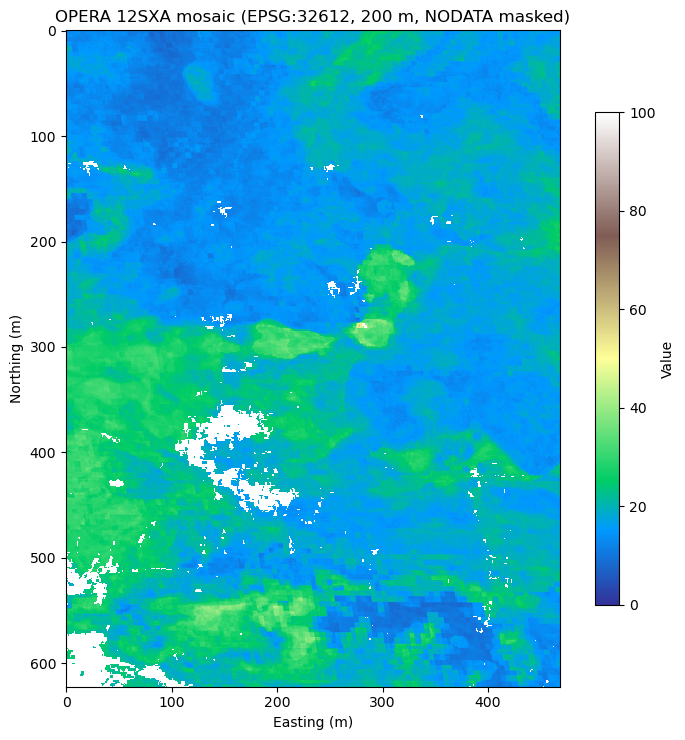

In [18]:
# ---- Plot (nodata masked) ----
# Your plotting code remains correct, assuming 'minx, maxx, miny, maxy' are defined
band0 = mosaic[0].astype(float)
band0[band0 == NODATA_VALUE] = np.nan
bandn = band0/10

# extent = (minx, maxx, miny, maxy)  # x0, x1, y0, y1 in meters
plt.figure(figsize=(7.5, 7.5))
im = plt.imshow(bandn, origin="upper", interpolation="nearest",
                 cmap='terrain', vmin=0, vmax=100)
plt.title("OPERA 12SXA mosaic (EPSG:32612, 200 m, NODATA masked)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(im, shrink=0.75, label="Value")
plt.tight_layout()
plt.show()

## 3.2) double check by reading clay_M01.int

## 4) Save COG-ready GeoTIFF

In [21]:
with rasterio.open(template_path) as tmp:
    dst_profile = tmp.profile
dst_profile.update({
    'driver': 'GTiff',
    'count': 1,
    'dtype': 'float32',
    'compress': 'deflate',
    'tiled': True,
})

save_path = Path(tgrid.get('template_path', '../data/outputs/aligned/clay_static_aligned.tif'))
out_path =  Path(save_path)
out_path.parent.mkdir(parents=True, exist_ok=True)
with rasterio.open(out_path, 'w', **dst_profile) as ds:
    ds.write(bandn, 1)
print('✅ Wrote', out_path)
print('Tip: To convert to full COG with overviews: `rio cogeo create clay_static_aligned.tif clay_static_aligned_cog.tif`')

✅ Wrote ../data/outputs/aligned/clay_static_aligned.tif
Tip: To convert to full COG with overviews: `rio cogeo create clay_static_aligned.tif clay_static_aligned_cog.tif`


---
### Notes
- If your clay is in **percentage**, you may want to convert to fraction prior to fusion.
- If a tile is in a different CRS, `reproject` handles it automatically.
- For large mosaics, consider windowed reading and `rasterio.merge.merge` to reduce memory.
- If your cache does **not** include EPSG:4326 bounds, adapt the overlap test to the tile CRS or preproject bounds into EPSG:4326 when generating the cache.
